# Street View House Numbers (SVHN) image classification

## Problem Statement

Street View House Numbers (SHVN) is a real-world image dataset that consists of images obtained from house numbers in Google street view images. The dataset can be used to automatically transcribe an address number from a geo-located patch of pixels and the associated transcribed number can be used to pinpoint the location of the building it represents.

The challenge in transcribing text from images is that the visual appearance of text in the image dataset varies based on large range of fonts, colours, styles, orientation and character arrangements. The problem is further complicated by environmental factors such as lighting, shadows, secularities and occlusions as well as image acquisition factors such as resolution, motion and focus blurs.

### Objective

The objective of the project is to learn how to implement a simple image classification pipeline based on deep neural network using Street View House Numbers (SVHN) dataset.

The goals of this project are as follows:



1.   Load Dataset
2.   Understand the basic Image Classification pipeline and the data-driven approach (train/predict stages)
3. Data fetching and understand the train/val/test splits.
4. Implement and apply a deep neural network classifier including (feedforward neural network, RELU, activations)
5. Implement batch normalization for training the neural network
6. Print the classification accuracy metrics



# Project Implementation

### Import necessary libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import logging
import random
import h5py
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Nadam
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

### Add setting for libraries

In [2]:
#Turn off warnings
logging.disable(logging.WARNING)

#Draw plots inline
%matplotlib inline

# Set seed for random
random.seed(1)

### Load the dataset

In [3]:
def load_data(path):
    """ Helper function for loading a MAT-File"""
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data('train_32x32.mat')
X_test, y_test = load_data('test_32x32.mat')

print("Training Set", X_train.shape, y_train.shape)
print("Test Set", X_test.shape, y_test.shape)

Training Set (32, 32, 3, 73257) (73257, 1)
Test Set (32, 32, 3, 26032) (26032, 1)


In [4]:
# Transpose the image arrays
X_train, y_train = X_train.transpose((3,0,1,2)), y_train[:,0]
X_test, y_test = X_test.transpose((3,0,1,2)), y_test[:,0]

print("Training Set", X_train.shape)
print("Test Set", X_test.shape)
print('')

# Calculate the total number of images
num_images = X_train.shape[0] + X_test.shape[0]

print("Total Number of Images", num_images)

Training Set (73257, 32, 32, 3)
Test Set (26032, 32, 32, 3)

Total Number of Images 99289


In [5]:
def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])

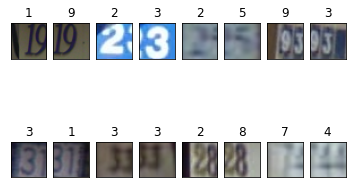

In [6]:
plot_images(X_train, y_train, 2, 8)

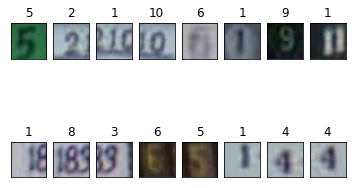

In [7]:
plot_images(X_test, y_test, 2, 8)

In [8]:
print(np.unique(y_train))

[ 1  2  3  4  5  6  7  8  9 10]


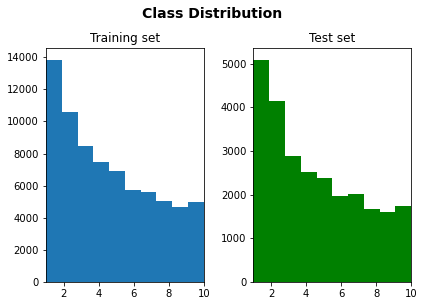

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train, bins=10)
ax1.set_title("Training set")
ax1.set_xlim(1, 10)

ax2.hist(y_test, color='g', bins=10)
ax2.set_title("Test set")

fig.tight_layout()

In [10]:
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

In [11]:
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.13, random_state=7)

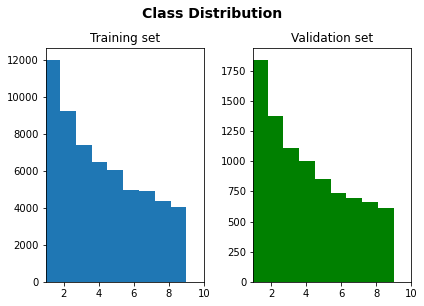

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train, bins=10)
ax1.set_title("Training set")
ax1.set_xlim(1, 10)

ax2.hist(y_val, color='g', bins=10)
ax2.set_title("Validation set")

fig.tight_layout()

In [14]:
y_train.shape, y_val.shape, y_test.shape

((63733,), (9524,), (26032,))

In [15]:
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

In [16]:
train_greyscale = rgb2gray(X_train).astype(np.float32)
test_greyscale = rgb2gray(X_test).astype(np.float32)
val_greyscale = rgb2gray(X_val).astype(np.float32)

In [17]:
print("Training Set", train_greyscale.shape)
print("Validation Set", val_greyscale.shape)
print("Test Set", test_greyscale.shape)

Training Set (63733, 32, 32, 1)
Validation Set (9524, 32, 32, 1)
Test Set (26032, 32, 32, 1)


In [18]:
import h5py

# Create file
h5f = h5py.File('SVHN_grey.h5', 'w')

# Store the datasets
h5f.create_dataset('X_train', data=train_greyscale)
h5f.create_dataset('y_train', data=y_train)
h5f.create_dataset('X_test', data=test_greyscale)
h5f.create_dataset('y_test', data=y_test)
h5f.create_dataset('X_val', data=val_greyscale)
h5f.create_dataset('y_val', data=y_val)

# Close the file
h5f.close()

In [19]:
h5f = h5py.File('SVHN_grey.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

# Close this file
h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (63733, 32, 32, 1) (63733,)
Validation set (9524, 32, 32, 1) (9524,)
Test set (26032, 32, 32, 1) (26032,)


In [20]:
X_train_flatten = X_train.reshape(X_train.shape[0], 1024).astype('float32')
X_val_flatten = X_val.reshape(X_val.shape[0], 1024).astype('float32')
X_test_flatten = X_test.reshape(X_test.shape[0], 1024).astype('float32')

In [21]:
X_train_flatten.shape

(63733, 1024)

In [22]:
X_val_flatten.shape

(9524, 1024)

In [23]:
X_test_flatten.shape

(26032, 1024)

In [24]:
X_train_norm = X_train_flatten/255
X_val_norm = X_val_flatten/255
X_test_norm = X_test_flatten/255

In [25]:
n_classes = 10
y_train_enc = to_categorical(y_train, n_classes)
y_val_enc = to_categorical(y_val, n_classes)
y_test_enc = to_categorical(y_test, n_classes)

In [26]:
X_train, X_val, X_test = X_train_norm, X_val_norm, X_test_norm

In [27]:
y_train, y_val, y_test = y_train_enc, y_val_enc, y_test_enc

### Understand the data

**The challenge in recognizing the images is evident from the above sample as some of the images are blur while others have multiple digits displayed. Also the same digit may appear different in different images**

### Data Pre-Processing

The following steps will be performed as part of data pre-processing

1.   Flatten the data
2.   Normalize the data
3.   Change the labels to one hot encoding



### Design the neural network architecure

### Model

We need to fine tune the architecture. We will make the following changes to architecture

1) One additional hidden layer

2) Increase the number of neurons to 128 in first hidden layer

3) Activation = 'selu'

4) No batch normalization (normalization taken care by selu activation)

5) No dropouts

6) Optimizer = 'nadam'

7) Batch Size = 128

**The neural network architecture design will have the following propoerties**

**Input Layer :**

* No. of neurons : **1024**


**Hidden Layer 1 :**

* No. of neurons : **128**

* Activation Function : **selu**

* kernel_initializer : **lecun_normal**

* Batch Normalization : **No**

**Hidden Layer 2 :**

* No. of neurons : **64**

* Activation Function : **selu**

* kernel_initializer : **lecun_normal**

* Batch Normalization : **No**

**Hidden Layer 3 :**

* No. of neurons : **64**

* Activation Function : **selu**

* kernel_initializer : **lecun_normal**

* Batch Normalization : **No**

**Hidden Layer 3 :**

* No. of neurons : **32**

* Activation Function : **selu**

* kernel_initializer : **lecun_normal**

* Batch Normalization : **No**


**Output Layer :**

* No. of neurons : **10**

* Activation Function : **Softmax**


**Additional properties of neural network**

* Optimizer : **nadam**

* Loss Function : **Cross Entropy**

* Batch Size : **128**

* Epoch : **25**

#### Define the architecture

In [28]:
# Define a sequential model
model = Sequential()

#First Hidden Layer
model.add(Dense(128, kernel_initializer='lecun_normal', activation='selu', input_shape=(1024,)))


#Second Hidden Layer
model.add(Dense(64, kernel_initializer='lecun_normal', activation='selu'))


# Third Hidden Layer
model.add(Dense(64, kernel_initializer='lecun_normal', activation='selu'))


# Fourth Hidden Layer
model.add(Dense(32, kernel_initializer='lecun_normal', activation='selu'))


#Output layer
model.add(Dense(10, activation='softmax'))

The model architecture is not using batch normalization as selu activation normalizes the data within the activation function itself. Since selu uses custom weight initialization, the model architecture uses lecun_normal as weight initialization.

#### Model summary

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 146,026
Trainable params: 146,026
Non-trainable params: 0
_________________________________________________________________


#### Configure the model

In [30]:
# The model will use nadam as optimizer and cross entropy as loss function
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Change the path of logs and create directory

In [32]:
#Define a model checkpoint callback which will be used to save weights for each spoch
output_path = 'Model_Output/'
modelcheckpoint = ModelCheckpoint(output_path + '/weights.{epoch:02d}.hdf5', save_weights_only=True)

In [33]:
# Train the model with batch size of 40 (which means each batch will have 1050 images) and epoch of 25. 
model.fit(X_train, y_train, batch_size = 128, epochs=25, verbose=1, callbacks=[modelcheckpoint], validation_data=(X_val, y_val))

Epoch 1/25
498/498 [==============================] - 4s 7ms/step - loss: 2.1204 - accuracy: 0.2476 - val_loss: 1.7926 - val_accuracy: 0.3753
Epoch 2/25
498/498 [==============================] - 3s 7ms/step - loss: 1.4609 - accuracy: 0.5144 - val_loss: 1.1752 - val_accuracy: 0.6274
Epoch 3/25
498/498 [==============================] - 3s 7ms/step - loss: 1.1787 - accuracy: 0.6237 - val_loss: 1.2208 - val_accuracy: 0.6063
Epoch 4/25
498/498 [==============================] - 3s 7ms/step - loss: 1.0439 - accuracy: 0.6720 - val_loss: 0.9611 - val_accuracy: 0.7020
Epoch 5/25
498/498 [==============================] - 3s 7ms/step - loss: 0.9574 - accuracy: 0.7005 - val_loss: 0.8633 - val_accuracy: 0.7366
Epoch 6/25
498/498 [==============================] - 3s 7ms/step - loss: 0.9003 - accuracy: 0.7181 - val_loss: 0.9002 - val_accuracy: 0.7154
Epoch 7/25
498/498 [==============================] - 3s 7ms/step - loss: 0.8487 - accuracy: 0.7341 - val_loss: 0.8290 - val_accuracy: 0.7446
Epoch 

The best validation accuracy that we achieved was the accuracy was 81% - 83%.

### Visualizing some predictions

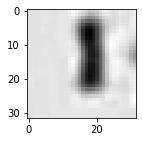

Label for the above image:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted label for above image:  [1]


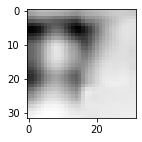

Label for the above image:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Predicted label for above image:  [7]


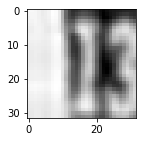

Label for the above image:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted label for above image:  [1]


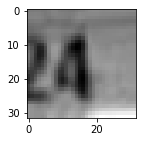

Label for the above image:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Predicted label for above image:  [4]


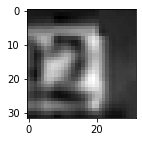

Label for the above image:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Predicted label for above image:  [4]


In [34]:
plt.figure(figsize=(2,2))
plt.imshow(X_test[13].reshape(32, 32), cmap="gray")
plt.show()

print("Label for the above image: ", y_test[13])
print("Predicted label for above image: ", model.predict_classes(X_test[13].reshape(1,1024)))


plt.figure(figsize=(2,2))
plt.imshow(X_test[240].reshape(32, 32), cmap="gray")
plt.show()

print("Label for the above image: ", y_test[240])
print("Predicted label for above image: ", model.predict_classes(X_test[240].reshape(1,1024)))



plt.figure(figsize=(2,2))
plt.imshow(X_test[1980].reshape(32, 32), cmap="gray")
plt.show()

print("Label for the above image: ", y_test[1980])
print("Predicted label for above image: ", model.predict_classes(X_test[1980].reshape(1,1024)))



plt.figure(figsize=(2,2))
plt.imshow(X_test[7645].reshape(32, 32), cmap="gray")
plt.show()

print("Label for the above image: ", y_test[7645])
print("Predicted label for above image: ", model.predict_classes(X_test[7645].reshape(1,1024)))


plt.figure(figsize=(2,2))
plt.imshow(X_test[12000].reshape(32, 32), cmap="gray")
plt.show()

print("Label for the above image: ", y_test[12000])
print("Predicted label for above image: ", model.predict_classes(X_test[12000].reshape(1,1024)))

### Conclusion

- Our Model Given Accuracy of 81% to 83%.